In [1]:
import os
import mypackages.myrasters as mr
import netCDF4
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

Specify the data directories where input data is stored and where output data will be stored:

In [2]:
data_dir = os.path.join('..', 'data')
out_dir = os.path.join('..', 'output/impact')

The data is in CDF format so we first need to open the dataset and then access the variables:

In [3]:
file_name = 'Earthstat/potato_AreaYieldProduction.nc'

in_filename = os.path.join(data_dir, file_name)
nc = netCDF4.Dataset(in_filename)

In [4]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(4320), latitude(2160), level(6), time(1)
    variables(dimensions): float64 longitude(longitude), float64 latitude(latitude), float64 level(level), float64 time(time), float32 potatoData(time,level,latitude,longitude)
    groups: 

In [5]:
var_name = 'potatoData'

potato = nc.variables[var_name]

In [6]:
potato

<class 'netCDF4._netCDF4.Variable'>
float32 potatoData(time, level, latitude, longitude)
    LayerDescriptions: struct(5).Data(:,:,1/2/3/4/5/6) to access data layer: 1=Harvested Area fraction, 2=Yield 3=Harvested Area data quality, 4=Yield data quality, 5=Harvested Area in hectares, 6= Production
    Units: Harvested Area Fraction(1)=percent of gridcell that was harvested, Yield(2)=metric tons per hectare, Harvested Area Hectares(5)=total hectares harvested per gridcell, Production(6)=Metric Tons
    DataQuality: In levels 3 and 4, a value of 1 = county; .75 = state; .5 = interpolated from within 2 degrees lat/long; .25 = country; 0 = missing.
    Citation: Monfreda, C., N. Ramankutty, and J.A. Foley (2008). Farming the planet. Part 2: Geographic distribution of crop areas, yields, physiological types, and net primary production in the year 2000. Global Biogeochemical Cycles 22, GB1022, doi:10.1029/2007GB002947.
    DataSource: Data downloaded from EarthStat.org. Data may be freely dow

In [7]:
a = potato[0][1].copy()
a = np.nan_to_num(a)
a[a > 0] = 1

/home/sothomas/miniconda3/envs/py36_gis2/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [8]:
b = mr.cut_array_yboundaries(array=a, pixelHeight=0.0833333, y_min_old=-90, y_min_new=-56, y_max_old=90, y_max_new=84)

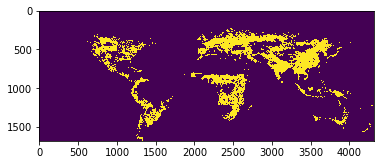

In [9]:
plt.imshow(b);

In [10]:
file_name = 'Earthstat/Cropland2000_5min.nc'
in_filename = os.path.join(data_dir, file_name)
nc = netCDF4.Dataset(in_filename)

In [11]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title:                                                                                 
    dimensions(sizes): longitude(4320), latitude(2160), level(1), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 level(level), float32 time(time), float32 farea(time,level,latitude,longitude)
    groups: 

In [12]:
var_name = 'farea'

crops = nc.variables[var_name]

In [13]:
crops

<class 'netCDF4._netCDF4.Variable'>
float32 farea(time, level, latitude, longitude)
    units:                                                                                 
    add_offset: 0.0
    scale_factor: 1.0
    missing_value: 9e+20
unlimited dimensions: time
current shape = (1, 1, 2160, 4320)
filling off

In [14]:
c = crops[0][0]
c = c.data
c[c == 9e20] = 0
c[a == 1] = 0
c[c > 0] = 1

In [15]:
d = mr.cut_array_yboundaries(array=c, pixelHeight=0.0833333, y_min_old=-90, y_min_new=-56, y_max_old=90, y_max_new=84)

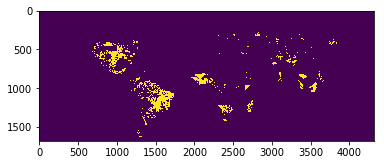

In [16]:
plt.imshow(d);

In [17]:
impact = mr.MyRaster(os.path.join(out_dir, 'impact_potato.tif'))

In [18]:
impact.show_raster_properties()

Driver:  GTiff
Projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
----------------------------------------------------------------------------------------------------
Size:  43200 x 16800 x 1
X min =  -180.0
X max =  180.0
Y min =  -56.00083279399999
Y max =  83.99916720600001
Origin = ( -180.0 , 83.99916720600001 )
Pixel Size = ( 0.008333333333333333 , -0.008333333333333333 )
No Data Value =  -1.0


In [19]:
potato_area = mr.resample_array_to_higher_resolution(b, 10)

In [20]:
potato_crop_area = mr.resample_array_to_higher_resolution(d, 10)

In [21]:
imp = impact.get_array()

In [22]:
impact_potato_area = imp.copy()

In [23]:
impact_potato_area[potato_area == 0] = -1
impact_potato_area = mr.mask_array(impact_potato_area, -1)

In [24]:
impact_potato_crop_area = imp.copy()

In [25]:
impact_potato_crop_area[potato_crop_area == 0] = -1
impact_potato_crop_area = mr.mask_array(impact_potato_crop_area, -1)

In [26]:
shapefile_name = 'shapefiles/countries.shp'
shapefile = os.path.join(data_dir, shapefile_name)

In [27]:
gdf = gpd.read_file(shapefile)

In [28]:
filename = 'non_crop_area.shp'
gdf2 = gpd.read_file(os.path.join(out_dir, filename))

In [29]:
vmin = 0
vmax = 0.5

CPU times: user 3min 17s, sys: 18.5 s, total: 3min 36s
Wall time: 3min 36s


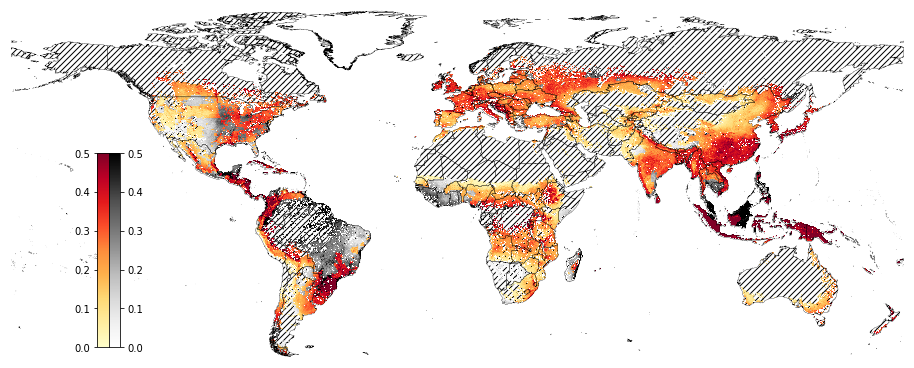

In [30]:
%%time

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

ax.set_xlim([-180, 180])
ax.set_ylim([-56, 84])
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

gdf.plot(ax=ax, facecolor='none', edgecolor='#000000', linewidths=0.3)

gdf2.plot(ax=ax, facecolor='none', edgecolor='#000000', linewidths=0, hatch='////')

ax.imshow(impact_potato_area, extent=[-180, 180, -56, 84], cmap='YlOrRd', vmin=vmin, vmax=vmax)
ax.imshow(impact_potato_crop_area, extent=[-180, 180, -56, 84], cmap='Greys', vmin=vmin, vmax=vmax)

norm = matplotlib.colors.Normalize(vmin, vmax, clip = False)

cax1 = fig.add_axes([0.2, 0.25, 0.01, 0.3]) # xmin, ymin, dx, dy
matplotlib.colorbar.ColorbarBase(cax1, cmap='YlOrRd', norm=norm)
cax1.yaxis.set_ticks_position('left')

cax2 = fig.add_axes([0.21, 0.25, 0.01, 0.3]) # xmin, ymin, dx, dy
matplotlib.colorbar.ColorbarBase(cax2, cmap='Greys', norm=norm)

plt.savefig(os.path.join(out_dir, 'impact_potato_crop_area.png'),
            dpi=300, bbox_inches='tight', pad_inches=0.1)

In [31]:
#"""
out_filename = 'impact_potato_area'
mr.array2geotiff_rastercopy(impact_potato_area, os.path.join(out_dir, out_filename), impact.raster)

out_filename = 'impact_potato_crop_area'
mr.array2geotiff_rastercopy(impact_potato_crop_area, os.path.join(out_dir, out_filename), impact.raster)
#"""

In [63]:
impact_potato_pot_area = imp.copy()

In [64]:
impact_potato_pot_area[(potato_area == 1) | (potato_crop_area == 1)] = -1
impact_potato_pot_area = mr.mask_array(impact_potato_pot_area, -1)

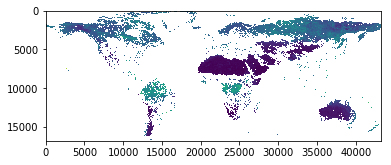

In [65]:
plt.imshow(impact_potato_pot_area);

In [66]:
#"""
out_filename = 'impact_potato_pot_area'
mr.array2geotiff_rastercopy(impact_potato_pot_area, os.path.join(out_dir, out_filename), impact.raster)
#"""